# Прогнозирование дорожного трафика с помощью A3T-GCN

In [1]:
import torch

## Исследование набора данных PeMS-M

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = ("https://github.com/VeritasYin/STGCN_IJCAI-18/"
       "raw/master/dataset/PeMSD7_Full.zip")

with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [3]:
import pandas as pd

speeds = pd.read_csv('PeMSD7_V_228.csv', names=range(0,228))
distances = pd.read_csv('PeMSD7_W_228.csv', names=range(0,228))

In [4]:
speeds

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.1,66.0,64.6,65.6,67.1,71.9,68.6,67.7,65.8,40.9,...,69.1,70.9,65.0,64.5,66.6,66.6,65.0,69.3,67.7,68.9
1,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
2,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
3,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
4,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12667,70.3,65.9,70.2,62.1,66.8,66.0,64.0,64.8,24.6,66.5,...,66.0,55.6,29.9,63.8,64.5,62.8,3.8,70.2,68.1,19.3
12668,69.9,54.0,68.2,62.2,67.4,65.8,64.4,61.3,35.1,69.2,...,66.8,62.8,29.9,62.9,66.6,63.0,3.5,68.2,68.3,18.9
12669,68.9,37.9,68.8,66.3,69.4,66.6,65.0,60.1,38.5,68.7,...,66.4,65.4,29.9,66.3,68.1,62.6,3.5,68.7,67.5,19.7
12670,69.2,37.8,68.7,63.6,68.5,66.2,64.1,60.9,40.5,68.5,...,67.6,68.9,30.2,64.8,68.2,63.1,3.7,67.7,67.4,19.5


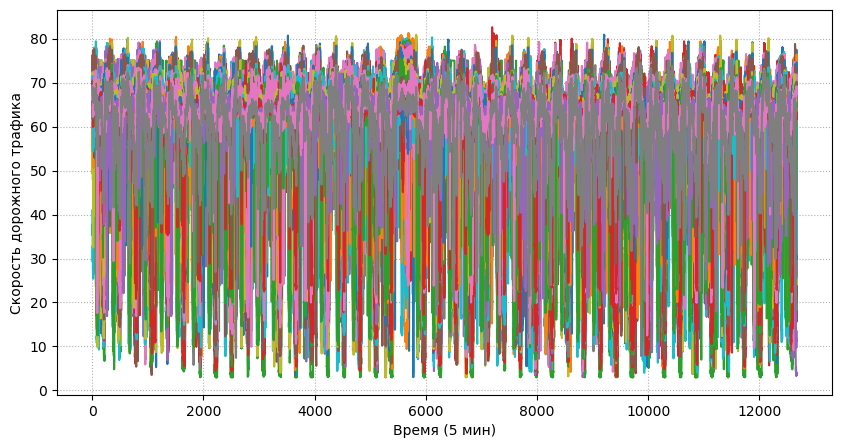

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=100) 
plt.plot(speeds) 
plt.grid(linestyle=':') 
plt.xlabel('Время (5 мин)') 
plt.ylabel('Скорость дорожного трафика');

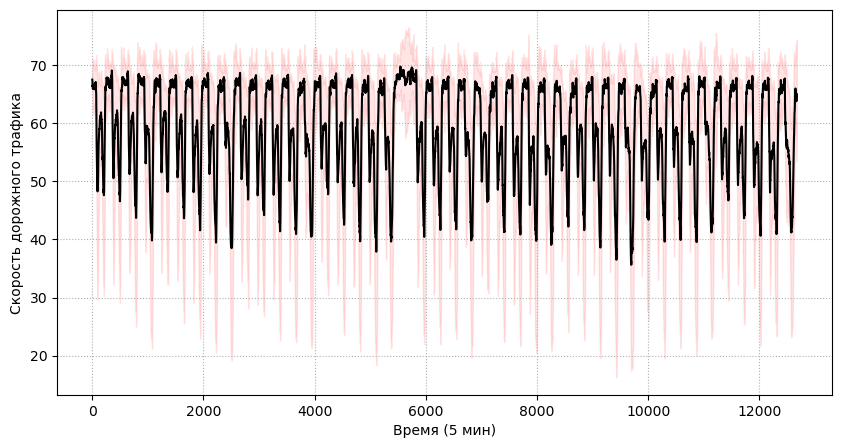

In [6]:
# визуализируем среднюю скорость движения 
# со стандартным отклонением
mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(mean, 'k-')
plt.grid(linestyle=':')
plt.fill_between(mean.index, 
                 mean-std, 
                 mean+std, 
                 color='r', 
                 alpha=0.1)
plt.xlabel('Время (5 мин)')
plt.ylabel('Скорость дорожного трафика');

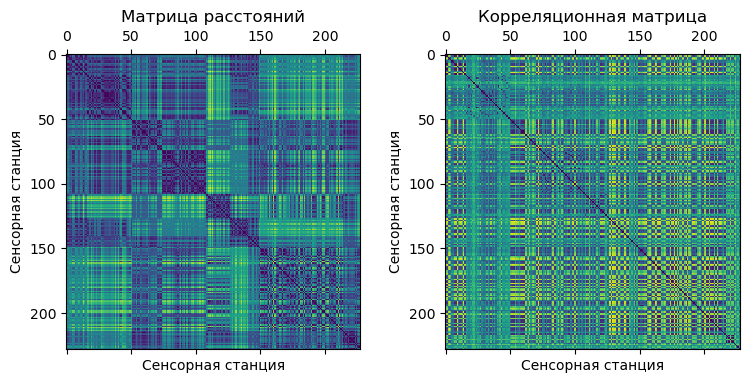

In [7]:
# мы также можем визуализировать корреляцию между
# временными рядами в различных маршрутах
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(distances)
ax1.set_xlabel("Сенсорная станция")
ax1.set_ylabel("Сенсорная станция")
ax1.title.set_text("Матрица расстояний")
ax2.matshow(-np.corrcoef(speeds.T))
ax2.set_xlabel("Сенсорная станция")
ax2.set_ylabel("Сенсорная станция")
ax2.title.set_text("Корреляционная матрица")

## Обработка набора данных

In [8]:
def compute_adj(distances, sigma2=0.1, epsilon=0.5):
    d = distances.to_numpy() / 10000.
    d2 = d * d
    n = distances.shape[0]  
    w_mask = np.ones([n, n]) - np.identity(n)
    return np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask

adj = compute_adj(distances)
adj[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.61266012, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

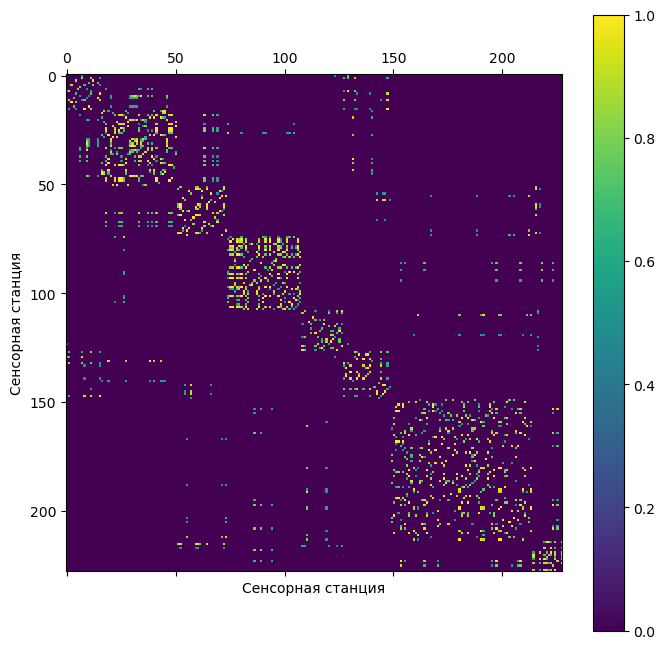

In [9]:
plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Сенсорная станция")
plt.ylabel("Сенсорная станция");

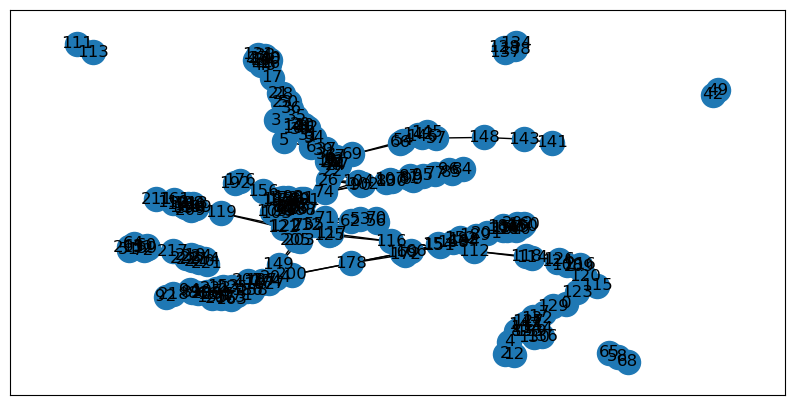

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw_networkx(G, with_labels=True)
    plt.show()

plot_graph(adj)

In [11]:
# пишем функцию нормализации
def zscore(x, mean, std):
    return (x - mean) / std

# выполняем нормализацию
speeds_norm = zscore(speeds, 
                     speeds.mean(axis=0), 
                     speeds.std(axis=0))
speeds_norm.head(1)

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,0.950754,0.548255,0.502211,0.831672,0.793696,1.193806,0.983384,0.737268,0.933144,-0.718118,...,0.542628,1.011204,0.609678,0.79198,0.709507,0.734163,0.569479,1.04614,0.712316,1.046962


In [12]:
# создаем набор данных
lags = 24
horizon = 48
xs = []
ys = []

for i in range(lags, speeds_norm.shape[0]-horizon):
    xs.append(speeds_norm.to_numpy()[i-lags:i].T)
    ys.append(speeds_norm.to_numpy()[i+horizon-1])

# преобразовываем матрицу смежности в индекс ребер (COO формат)
edge_index = (np.array(adj) > 0).nonzero()
edge_index

(array([  0,   0,   0, ..., 227, 227, 227]),
 array([  7, 123, 129, ..., 221, 222, 224]))

In [13]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

dataset = StaticGraphTemporalSignal(edge_index, 
                                    adj[adj > 0], 
                                    xs, ys)
dataset[0]

2024-03-20 18:36:43.284926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/torch_geometric_temporal/signal/static_graph_temporal_signal.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.LongTensor(self.edge_index)


Data(x=[228, 24], edge_index=[2, 1664], edge_attr=[1664], y=[228])

In [14]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

## Implementing the A3T-GCN architecture

In [15]:
import torch
from torch_geometric_temporal.nn.recurrent import A3TGCN


class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, 
                           out_channels=32, 
                           periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(lags, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
model.train()
print(model)

# обучение
for epoch in range(30):
    loss = 0
    step = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x.unsqueeze(2), 
                       snapshot.edge_index, 
                       snapshot.edge_attr)
        loss += torch.mean((y_pred-snapshot.y)**2)
        step += 1
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 5 == 0:
        print(f"Эпоха {epoch:>2} | MSE на обучении: {loss:.4f}")

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(24, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(24, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(24, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
Эпоха  0 | MSE на обучении: 0.9945
Эпоха  5 | MSE на обучении: 0.9656
Эпоха 10 | MSE на обучении: 0.9459
Эпоха 15 | MSE на обучении: 0.9279
Эпоха 20 | MSE на обучении: 0.9132
Эпоха 25 | MSE на обучении: 0.9016


In [16]:
def inverse_zscore(x, mean, std):
    return x * std + mean

y_test = []
for snapshot in test_dataset:
    y_hat = snapshot.y.numpy()
    y_hat = inverse_zscore(y_hat, 
                           speeds.mean(axis=0), 
                           speeds.std(axis=0))
    y_test = np.append(y_test, y_hat)

gnn_pred = []
model.eval()
for snapshot in test_dataset:
    snapshot = snapshot
    y_hat = model(snapshot.x.unsqueeze(2), 
                  snapshot.edge_index, 
                  snapshot.edge_weight).squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, 
                           speeds.mean(axis=0), 
                           speeds.std(axis=0))
    gnn_pred = np.append(gnn_pred, y_hat)

In [17]:
def MAE(real, pred):
    return np.mean(np.abs(pred - real))

def RMSE(real, pred):
    return np.sqrt(np.mean((pred - real) ** 2))

def MAPE(real, pred):
    return np.mean(np.abs(pred - real) / (real + 1e-5))

print(f'GNN MAE  = {MAE(gnn_pred, y_test):.4f}')
print(f'GNN RMSE = {RMSE(gnn_pred, y_test):.4f}')
print(f'GNN MAPE = {MAPE(gnn_pred, y_test):.4f}')

GNN MAE  = 8.2998
GNN RMSE = 11.9450
GNN MAPE = 0.1490


In [18]:
rw_pred = []
for snapshot in test_dataset:
    y_hat = snapshot.x[:,-1].squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, 
                           speeds.mean(axis=0), 
                           speeds.std(axis=0))
    rw_pred = np.append(rw_pred, y_hat)

print(f'RW MAE  = {MAE(rw_pred, y_test):.4f}')
print(f'RW RMSE = {RMSE(rw_pred, y_test):.4f}')
print(f'RW MAPE = {MAPE(rw_pred, y_test):.4f}')

RW MAE  = 11.0469
RW RMSE = 17.6501
RW MAPE = 0.2999


In [19]:
ha_pred = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    y_hat = speeds_norm.to_numpy()[:i].T.mean(axis=1)
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), 
                           speeds.std(axis=0)) 
    ha_pred.append(y_hat)
ha_pred = np.array(ha_pred).flatten()[-len(y_test):]

print(f'HA MAE  = {MAE(ha_pred, y_test):.4f}')
print(f'HA RMSE = {RMSE(ha_pred, y_test):.4f}')
print(f'HA MAPE = {MAPE(ha_pred, y_test):.4f}')

HA MAE  = 9.3374
HA RMSE = 13.1518
HA MAPE = 0.1633


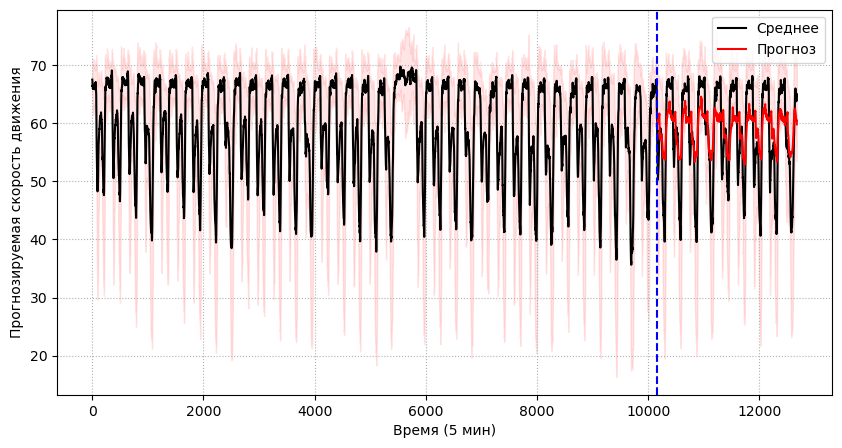

In [20]:
y_preds = [inverse_zscore(
    model(snapshot.x.unsqueeze(2), snapshot.edge_index, 
          snapshot.edge_weight).squeeze().detach().numpy(), 
    speeds.mean(axis=0), 
    speeds.std(axis=0)).mean() for snapshot in test_dataset]

mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5))
plt.plot(np.array(mean), 'k-', label='Среднее')
plt.plot(range(len(speeds)-len(y_preds), 
               len(speeds)), y_preds, 
         'r-', 
         label='Прогноз')
plt.grid(linestyle=':')
plt.fill_between(mean.index, 
                 mean-std, 
                 mean+std, 
                 color='r', 
                 alpha=0.1)
plt.axvline(x=len(speeds)-len(y_preds), 
            color='b', 
            linestyle='--')
plt.xlabel('Время (5 мин)')
plt.ylabel('Прогнозируемая скорость движения')
plt.legend(loc='upper right');